### analyzing the latest experiment results

#### Setup and data loading
This notebook uses DuckDB to query Parquet event datasets under `results/**/parquet/events` without loading everything into memory. If DuckDB isn't installed, please `pip install duckdb`.

In [1]:
# print all files in the current working directory
import os
import glob
print(os.listdir('.'))

from pathlib import Path

current_dir = Path('.')

directories = sorted([p for p in (current_dir / 'results_parquet/events').glob('**/grid_id*') if p.is_dir()])

# print number of found grid id partitions
print(f"Found {len(directories)} grid id partitions")

['runner.py', 'analysis.ipynb', 'README.md', 'cli.py', 'exp_integration.py', 'configs', 'demos', '__pycache__', 'results', 'tests', 'grid_runner.py', 'utils', 'results_parquet']
Found 288 grid id partitions


In [2]:
# Imports and display config
import os, sys, json, math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Optional plotting enhancements
try:
    import seaborn as sns
    sns.set_theme()
except Exception:
    sns = None

# DuckDB for fast, low-memory Parquet scans
# use the previous list of files

try:
    import duckdb
    HAVE_DUCKDB = True
except Exception:
    HAVE_DUCKDB = False
    # Change to read from the specified folder
    BASE_RESULTS = Path('results_parquet')
    EVENT_DATASETS = [BASE_RESULTS / 'events'] if (BASE_RESULTS / 'events').is_dir() else []
    if not EVENT_DATASETS:
        raise FileNotFoundError("No 'events' datasets found under the specified path.")
    events_dir = EVENT_DATASETS[0]  # Use the single events directory
    base_parquet_dir = events_dir.parent
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

# Discover event-level Parquet datasets under results/**/parquet/events
BASE_RESULTS = Path('results_parquet')
directories = sorted([p for p in (current_dir / 'results_parquet/events').glob('**/grid_id*') if p.is_dir()])
if not directories:
    raise FileNotFoundError("No 'events' datasets found under results_parquet/**/parquet/")

# Establish a DuckDB connection and create an 'events' view
if not HAVE_DUCKDB:
    raise RuntimeError('DuckDB not installed; please `pip install duckdb` for low-memory analysis.')
con = duckdb.connect()
# Optional: cap DuckDB memory usage to avoid OOM (adjust as needed)
try:
    con.execute("SET memory_limit='1GB'")
except Exception:
    pass
events_dir = BASE_RESULTS / 'events'
pat = str(events_dir / '**/*.parquet')
con.execute(f"CREATE OR REPLACE VIEW events AS SELECT * FROM read_parquet('{pat}')")
# Inspect available columns once for conditional logic later and sort for consistency
# also include the grid ID in the events view
cols = sorted([d[0] for d in con.execute(f"SELECT * FROM read_parquet('{pat}') LIMIT 1").description])
print('Columns available:', cols)


Columns available: ['C_hat_1', 'D_hat', 'G_hat', 'N_gamma', 'PT_target_residual', 'P_T', 'P_T_est', 'P_T_true', 'ST_running', 'ST_target_residual', 'S_scalar', 'acc', 'accountant', 'avg_regret', 'avg_regret_with_noise', 'base_eta_t', 'c_hat', 'clip_applied', 'comparator_type', 'cum_regret', 'cum_regret_with_noise', 'd_norm', 'delta_P', 'delta_step_theory', 'delta_total', 'drift_boost_remaining', 'drift_flag', 'eps_remaining', 'eps_spent', 'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type', 'g_norm', 'grid_id', 'lambda_est', 'lambda_raw', 'm_capacity', 'm_used', 'noise', 'noise_regret_cum', 'noise_regret_increment', 'op', 'pair_admitted', 'pair_damped', 'path_regret_increment', 'privacy_spend_running', 'regret', 'regret_dynamic', 'regret_increment', 'regret_path_term', 'regret_static_term', 'rho_remaining', 'rho_spent', 'rho_step', 'sample_id', 'sc_active', 'sc_stable', 'seed', 'segment_id', 'sens_delete', 'sigma_delete', 'sigma_step', 'sigma_step_theory', 'static_regret_incr

In [3]:
# Minimal peek at a few rows for schema intuition (safe LIMIT)
peek = con.execute('SELECT * FROM events LIMIT 5').df()
print('Peek at events (5 rows):')
peek


Peek at events (5 rows):


,event_type,event,op,regret,acc,sample_id,event_id,segment_id,x_norm,delta_P,w_star_norm,noise,theory_targets,G_hat,D_hat,c_hat,C_hat_1,P_T_true,g_norm,clip_applied,ST_running,PT_target_residual,ST_target_residual,sigma_step,privacy_spend_running,sigma_step_theory,S_scalar,eta_t,lambda_est,eps_step_theory,delta_step_theory,rho_step,P_T,comparator_type,drift_flag,regret_dynamic,regret_static_term,regret_path_term,sens_delete,P_T_est,drift_boost_remaining,base_eta_t,regret_increment,cum_regret,avg_regret,noise_regret_increment,noise_regret_cum,cum_regret_with_noise,avg_regret_with_noise,N_gamma,lambda_raw,sc_stable,pair_admitted,pair_damped,d_norm,sc_active,static_regret_increment,path_regret_increment,accountant,m_capacity,m_used,eps_spent,eps_remaining,rho_spent,rho_remaining,delta_total,stepsize_policy,stepsize_params,sigma_delete,grid_id,seed
0,calibrate,0,calibrate,0.0,0.078950,theory_000000,0,0,4.792816,0.012088,1.0,-0.012853,"{'accountant': 'zcdp', 'delta_total': 1e-05, '...",2.0,2.0,0.1,10.0,0.012088,1.414214,False,2.0,-0.000002,6.661338e-16,NaN,0.0,<NA>,0.143180,1.000000,22.971081,<NA>,<NA>,<NA>,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,22.971081,1,True,False,0.378392,False,0.0,0.0,zcdp,0,0,<NA>,<NA>,0.0,2.0,0.00001,adagrad,"{'D': 1.0, 'S_t': 0.14318024681055883, 'eta_fo...",NaN,00e99e682eb2,0
1,calibrate,1,calibrate,0.0,1.054943,theory_000001,1,0,6.101241,0.012088,1.0,0.136646,<NA>,2.0,2.0,0.1,10.0,0.024176,1.414214,False,4.0,-0.000003,4.440892e-16,NaN,0.0,<NA>,41.667551,0.154918,24.396459,<NA>,<NA>,<NA>,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.154918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,37.224863,2,True,False,0.280524,False,0.0,0.0,zcdp,0,0,<NA>,<NA>,0.0,2.0,0.00001,adagrad,"{'D': 1.0, 'S_t': 41.66755052059967, 'eta_form...",NaN,00e99e682eb2,0
2,calibrate,2,calibrate,0.0,0.017949,theory_000002,2,0,3.925308,0.012088,1.0,-0.066519,<NA>,2.0,2.0,0.1,10.0,0.036264,1.414214,False,6.0,-0.000005,2.960595e-16,NaN,0.0,<NA>,41.673479,0.154907,23.228520,<NA>,<NA>,<NA>,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.154907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,12.717073,3,True,False,0.002464,False,0.0,0.0,zcdp,0,0,<NA>,<NA>,0.0,2.0,0.00001,adagrad,"{'D': 1.0, 'S_t': 41.67347948362512, 'eta_form...",NaN,00e99e682eb2,0
3,calibrate,3,calibrate,0.0,0.624162,theory_000003,3,0,5.963473,0.012088,1.0,0.035151,<NA>,2.0,2.0,0.1,10.0,0.048352,1.414214,False,8.0,-0.000007,2.220446e-16,NaN,0.0,<NA>,55.500063,0.134231,24.300617,<NA>,<NA>,<NA>,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.134231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,33.949488,4,True,False,0.252233,False,0.0,0.0,zcdp,0,0,<NA>,<NA>,0.0,2.0,0.00001,adagrad,"{'D': 1.0, 'S_t': 55.50006268115823, 'eta_form...",NaN,00e99e682eb2,0
4,calibrate,4,calibrate,0.0,0.441909,theory_000004,4,0,4.034577,0.012088,1.0,0.090347,<NA>,2.0,2.0,0.1,10.0,0.060440,1.414214,False,10.0,-0.000008,1.776357e-16,NaN,0.0,<NA>,58.700328,0.130521,23.491019,<NA>,<NA>,<NA>,0.0,none,False,0.0,0.0,0.0,<NA>,0.0,0,0.130521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16.204632,5,True,False,0.051923,False,0.0,0.0,zcdp,0,0,<NA>,<NA>,0.0,2.0,0.00001,adagrad,"{'D': 1.0, 'S_t': 58.70032812578957, 'eta_form...",NaN,00e99e682eb2,0


In [4]:
# Load grid parameters from grids/grid_id=*/params.json (small)
def load_grid_params(base_parquet_dir: Path) -> pd.DataFrame:
    grids_root = base_parquet_dir / 'grids'
    rows = []
    if not grids_root.exists():
        return pd.DataFrame()
    for params_path in grids_root.rglob('params.json'):
        try:
            gid = params_path.parent.name.split('=',1)[1]
            with open(params_path, 'r') as f:
                params = json.load(f)
            params['grid_id'] = gid
            rows.append(params)
        except Exception:
            continue
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows)

params_df = load_grid_params(Path('results_parquet'))
print('params_df:', params_df.shape)
params_df.head(3)


params_df: (288, 71)


,C_hat,D_bound,D_cap,D_hat,G_hat,accountant,adagrad_eps,adaptive_geometry,adaptive_privacy,algo,alphas,bootstrap_iters,c_hat,comparator,d_max,dataset,delete_ratio,delta_b,delta_total,disable_regret_gate,drift_adaptation,drift_kappa,drift_mode,drift_rate,drift_threshold,drift_window,dynamic_comparator,ema_beta,enable_oracle,enforce_nonnegative_regret,eps_total,eta_max,gamma_bar,gamma_split,grid_id,hessian_clamp_eps,lambda_,lambda_cap,lambda_est_beta,lambda_est_bounds,lambda_floor,lambda_min_threshold,lambda_reg,lambda_stability_K,lambda_stability_min_steps,m_max,max_events,online_standardize,output_granularity,pair_admission_m,parquet_only_mode,parquet_out,quantile,recal_threshold,recal_window,regret_comparator_mode,regret_warmup_threshold,relaxation_factor,rho_total,rotate_angle,sens_calib,strong_convexity,target_C,target_D,target_G,target_PT,target_ST,target_c,target_lambda,trim_quantile,window_erm
0,None,1.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",1000,None,dynamic,inf,synthetic,20,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.22,0.64,6c08c0589eb5,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,None,20000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,2.00,0.01,50,True,10.0,2.0,2.0,100.0,40000.0,0.1,0.05,0.95,False
1,None,1.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",1000,None,dynamic,inf,synthetic,20,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.32,0.70,548c780859a3,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,None,20000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,0.50,0.01,50,True,10.0,2.0,2.0,100.0,40000.0,0.1,0.05,0.95,False
2,None,1.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",1000,None,dynamic,inf,synthetic,20,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,False,True,1.0,1.0,0.28,0.67,fb45224854a5,0.0,0.05,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,None,20000,False,seed,0.000001,True,results_parquet,0.95,0.3,None,oracle,None,0.8,0.25,0.01,50,True,10.0,2.0,2.0,400.0,40000.0,0.1,0.05,0.95,False


In [5]:
# Per-seed summary using DuckDB aggregation (low-memory)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
has_op = 'op' in cols
has_regret = 'regret' in cols
has_acc = 'acc' in cols
has_eps = 'eps_spent' in cols

selects = [
    'grid_id',
    'seed',
    'COUNT(*) AS events'
]
if has_op:
    selects += [
        "SUM(CASE WHEN op = 'insert' THEN 1 ELSE 0 END) AS inserts",
        "SUM(CASE WHEN op = 'delete' THEN 1 ELSE 0 END) AS deletions",
    ]
if has_regret:
    selects += [
        'AVG(regret) AS avg_regret',
        'STDDEV_SAMP(regret) AS regret_std'
    ]
if has_acc:
    selects.append('AVG(acc) AS avg_acc')
if has_eps:
    # Approx final epsilon via max if no event order column exists
    # (for monotone spend this is fine).
    selects.append('MAX(eps_spent) AS final_eps_spent')

sql = f"SELECT {', '.join(selects)} FROM events GROUP BY grid_id, seed"
summary = con.execute(sql).df()
print('summary shape:', summary.shape)
summary.head(10)


summary shape: (1440, 9)


,grid_id,seed,events,inserts,deletions,avg_regret,regret_std,avg_acc,final_eps_spent
0,ffe56e3d2a0c,4,19950,15792.0,3158.0,0.132929,0.401360,0.575348,<NA>
1,ffe56e3d2a0c,2,19950,15792.0,3158.0,0.192084,0.419364,0.590570,<NA>
2,ffc2f90fa8b5,2,19950,9475.0,9475.0,0.126832,0.316921,0.516890,<NA>
3,ffc2f90fa8b5,1,19950,9475.0,9475.0,0.275151,0.536776,0.654576,<NA>
4,ffc2f90fa8b5,0,19950,9475.0,9475.0,0.005055,0.109538,0.345458,<NA>
5,feda0a09c504,2,19950,18048.0,902.0,0.125572,0.316008,0.515234,<NA>
6,feda0a09c504,0,19950,18048.0,902.0,0.004549,0.108891,0.341874,<NA>
7,fea52c6c7e45,3,19950,18048.0,902.0,0.221145,0.575737,0.686351,<NA>
8,fea52c6c7e45,2,19950,18048.0,902.0,0.153739,0.359870,0.547827,<NA>
9,fea52c6c7e45,1,19950,18048.0,902.0,0.348502,0.644089,0.720837,<NA>


## Analyzing the Per-Seed Summary

There only appears to be one `grid_id` that was tested for this run of simulations.

I'm re-running the `grid_runner` command to produce a wider range of results. But if the results continue to write to a single grid_id partition, then I'll have to investigate the reason.

Seeds 0-3 have the same number of events.

Seeds 0-2 have the same number of insertions and deletions.

The `avg_regret` for seed 0 is much lower than the other seeds at ~0.0058, while seed 4 comes in next at 0.186.



In [6]:
# Grid-level summary aggregated across seeds (DuckDB)
tmp = duckdb.from_df(summary)
agg_parts = [
    'COUNT(*) AS seeds',
    'SUM(events) AS total_events'
]
if 'avg_regret' in summary.columns:
    agg_parts.append('AVG(avg_regret) AS mean_regret')
if 'avg_acc' in summary.columns:
    agg_parts.append('AVG(avg_acc) AS mean_acc')
if 'final_eps_spent' in summary.columns:
    agg_parts.append('MAX(final_eps_spent) AS max_eps_spent')
grid_summary = tmp.aggregate(f"grid_id, {', '.join(agg_parts)}")
grid_summary = grid_summary.df()

# Attach a few params for context if available (small join)
if not params_df.empty:
    keep_cols = ['grid_id'] + [c for c in ['algo','accountant','gamma_bar','gamma_split','lambda_reg','lambda_','target_PT','eps_total','rho_total'] if c in params_df.columns]
    grid_summary = grid_summary.merge(params_df[keep_cols].drop_duplicates('grid_id'), on='grid_id', how='left')

grid_summary.sort_values('mean_regret' if 'mean_regret' in grid_summary.columns else 'total_events').head(20)


,grid_id,seeds,total_events,mean_regret,mean_acc,max_eps_spent,algo,accountant,gamma_bar,gamma_split,lambda_reg,lambda_,target_PT,eps_total,rho_total
181,121f0a011fec,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.28,0.67,0.05,0.05,400.0,1.0,1.00
73,3bf09d80fa9a,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.28,0.67,0.05,0.05,400.0,1.0,0.50
236,32a211ed2281,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.32,0.70,0.05,0.05,400.0,1.0,0.50
49,756c517717d3,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.36,0.74,0.05,0.05,400.0,1.0,0.25
107,38dcfdf26fe2,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.36,0.74,0.05,0.05,400.0,1.0,2.00
66,568dad19d04c,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.36,0.74,0.05,0.05,400.0,1.0,0.50
216,a4e596c9c49b,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.22,0.64,0.05,0.05,400.0,1.0,0.50
131,1b9080fcb003,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.22,0.64,0.05,0.05,400.0,1.0,2.00
26,9ed5e3777572,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.32,0.70,0.05,0.05,400.0,1.0,2.00
136,151b81876b7d,5,99750.0,0.104324,0.499841,<NA>,memorypair,zcdp,0.28,0.67,0.05,0.05,400.0,1.0,0.25


In [7]:
# Quick op-type summary using DuckDB (no full load)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'op' in cols:
    if 'regret' in cols:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count, AVG(regret) AS avg_regret
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
    else:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
op_summary


,op,count,avg_regret
0,insert,20460776,0.168947
1,delete,6393520,0.168003
2,calibrate,1440000,0.000000
3,warmup,433704,0.232365


all_events shape: (100000, 3)


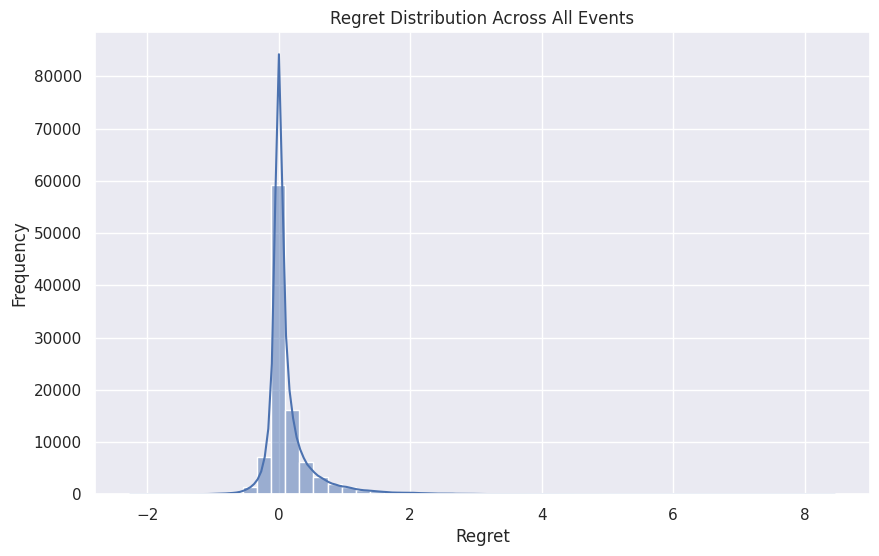

In [8]:
# visualize regret distribution if available (sample 100k rows if large)  
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])  
if 'regret' in cols:
    all_events = con.execute("SELECT grid_id, seed, regret FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.histplot(all_events['regret'], bins=50, kde=True)
        plt.title('Regret Distribution Across All Events')
        plt.xlabel('Regret')
        plt.ylabel('Frequency')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['regret'], bins=50)
        plt.title('Regret Distribution Across All Events')
        plt.xlabel('Regret')
        plt.ylabel('Frequency')
        plt.show()

all_events shape: (100000, 3)


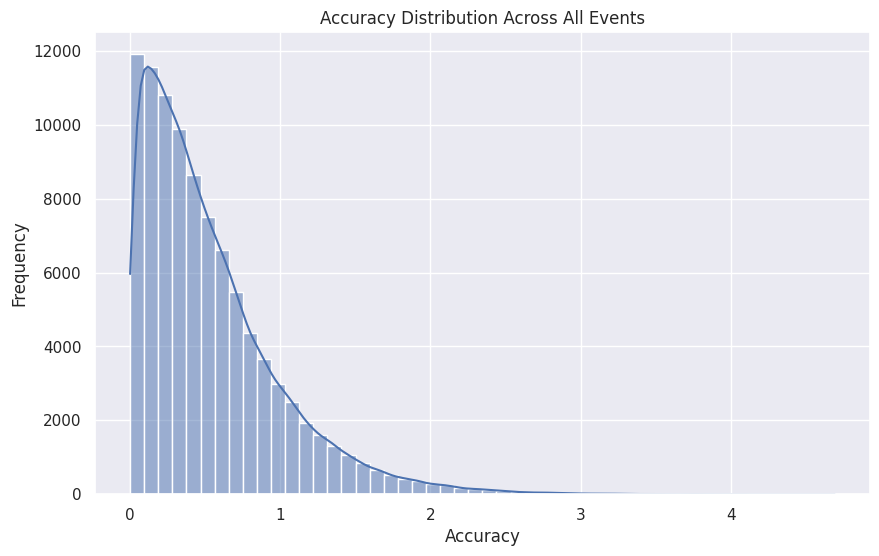

In [9]:
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'acc' in cols:
    all_events = con.execute("SELECT grid_id, seed, acc FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.histplot(all_events['acc'], bins=50, kde=True)
        plt.title('Accuracy Distribution Across All Events')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['acc'], bins=50)
        plt.title('Accuracy Distribution Across All Events')
        plt.xlabel('Accuracy')
        plt.ylabel('Frequency')
        plt.show()

all_events shape: (100000, 4)


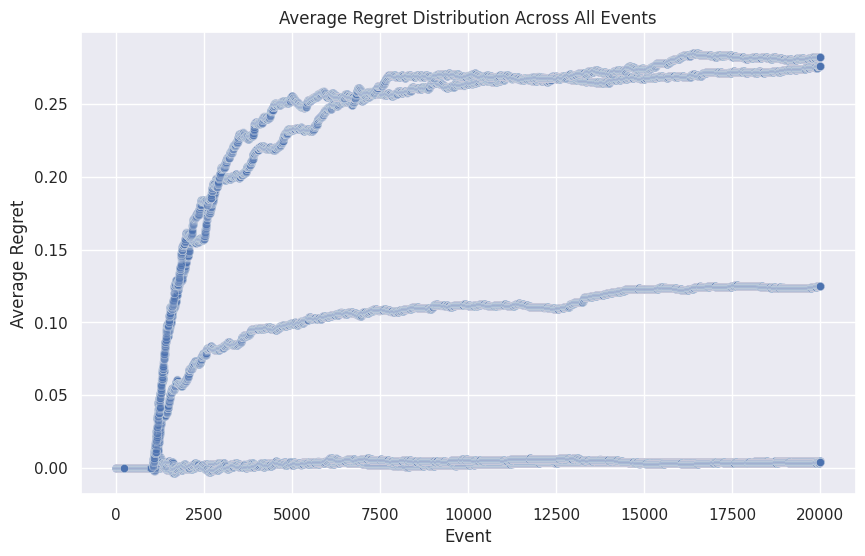

In [10]:
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols:
    all_events = con.execute("SELECT grid_id, seed, event, avg_regret FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=all_events, x='event', y='avg_regret',alpha=0.1)
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Event')
        plt.ylabel('Average Regret')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.hist(all_events['avg_regret'], bins=50)
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Average Regret')
        plt.ylabel('Frequency')
        plt.show()
        plt.title('Average Regret Distribution Across All Events')
        plt.xlabel('Average Regret')
        plt.ylabel('Frequency')
        plt.show()

Grid ID: fca2b91a9f92, shape: (99750, 2)


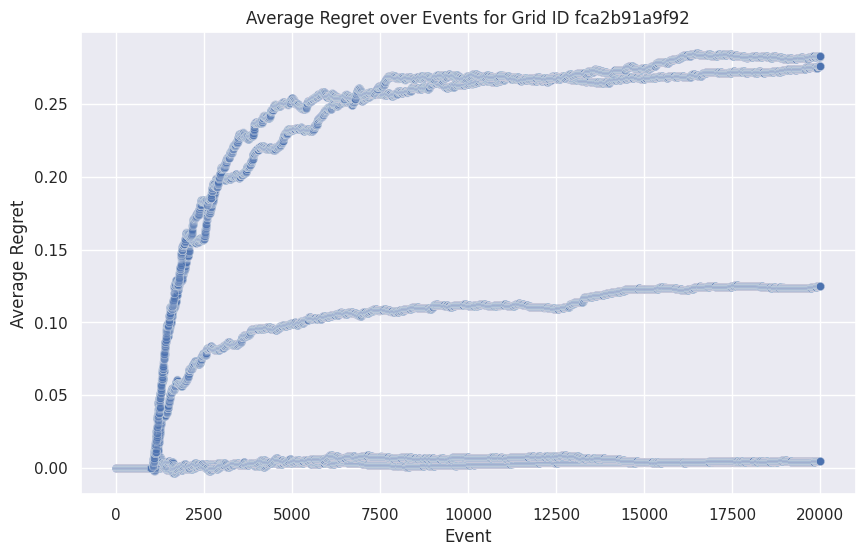

Grid ID: fbe1e02b3d0b, shape: (99750, 2)


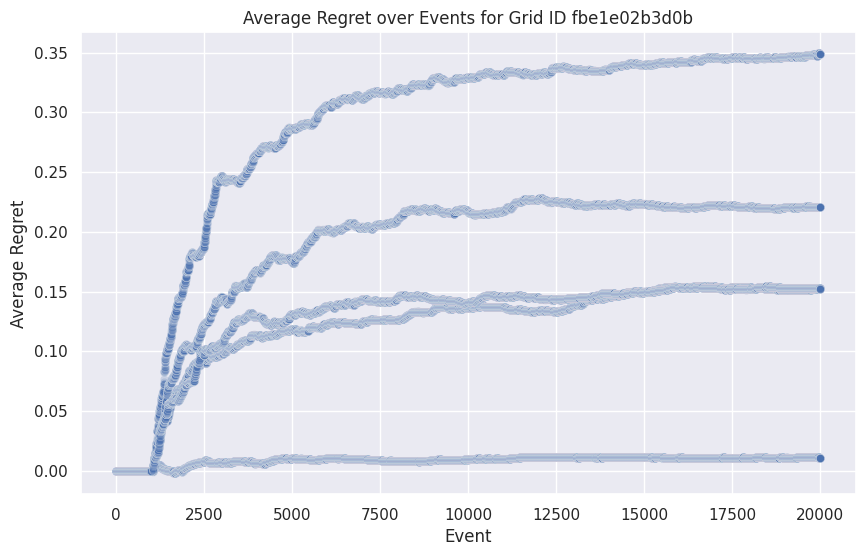

Grid ID: f88133fb27fa, shape: (99750, 2)


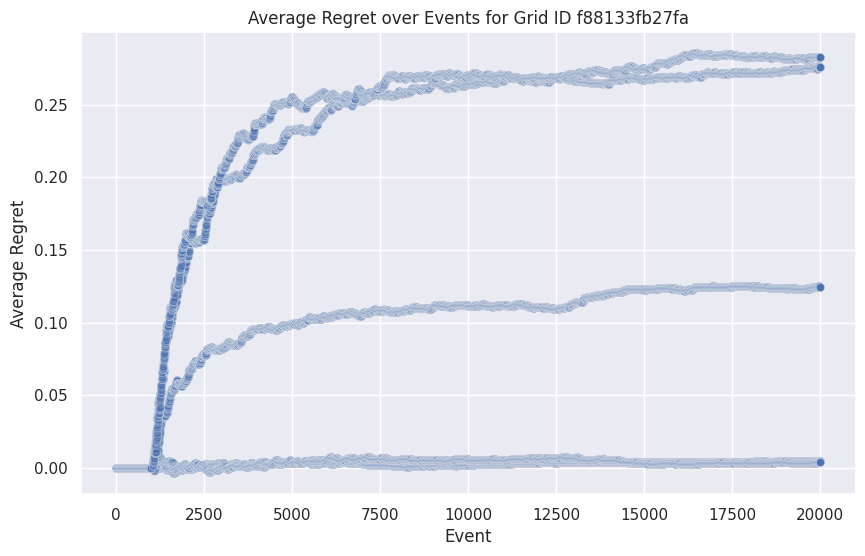

Grid ID: f2a5194fc897, shape: (99750, 2)


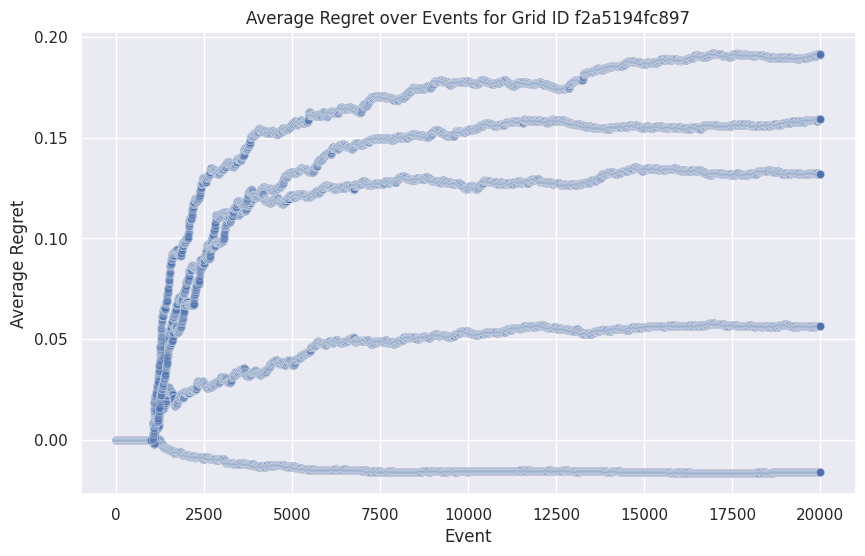

In [11]:
# plot one grid id per axis if regret and event columns exist
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols and 'event' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        grid_events = con.execute(f"SELECT event, avg_regret FROM events WHERE grid_id = '{gid}' LIMIT 100000").df()
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        if sns is not None:
            plt.figure(figsize=(10,6))
            sns.scatterplot(data=grid_events, x='event', y='avg_regret', alpha=0.1)
            plt.title(f'Average Regret over Events for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.show()
        else:
            plt.figure(figsize=(10,6))
            plt.scatter(grid_events['event'], grid_events['avg_regret'], alpha=0.1)
            plt.title(f'Average Regret over Events for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.show()

Grid ID: fca2b91a9f92, shape: (5000, 3)


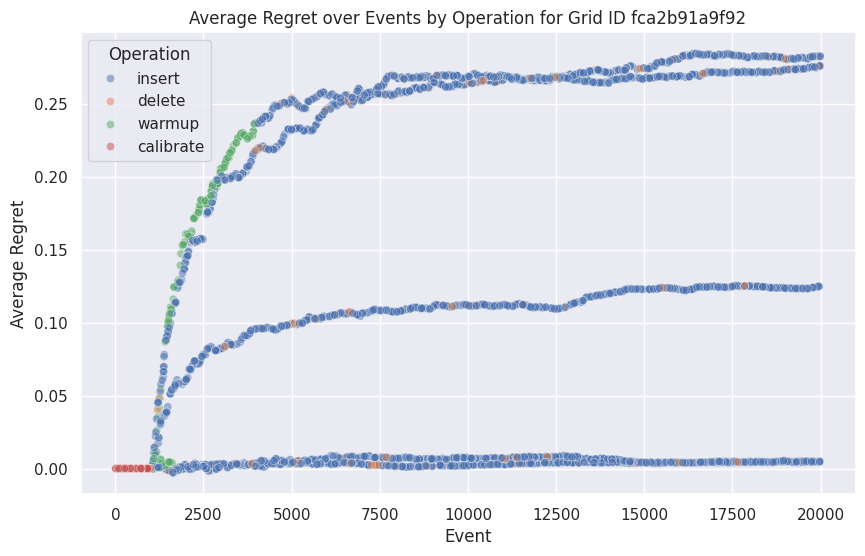

Grid ID: fbe1e02b3d0b, shape: (5000, 3)


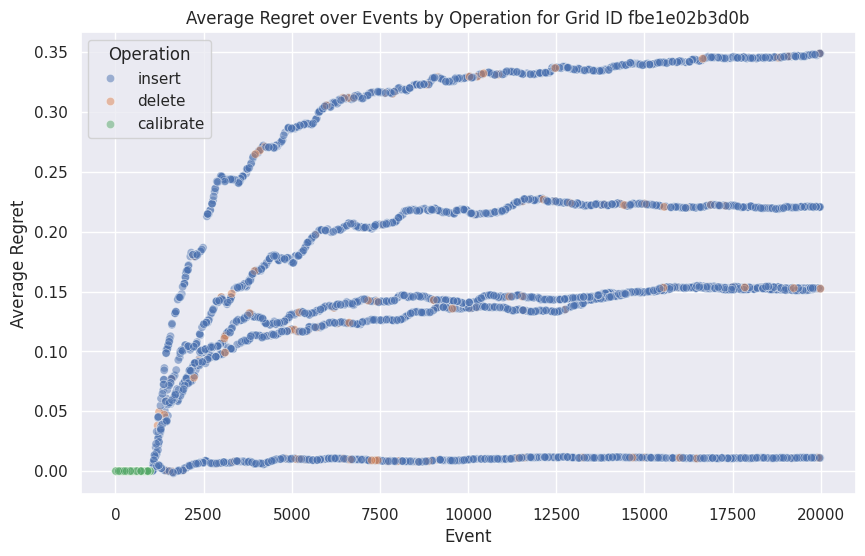

Grid ID: f88133fb27fa, shape: (5000, 3)


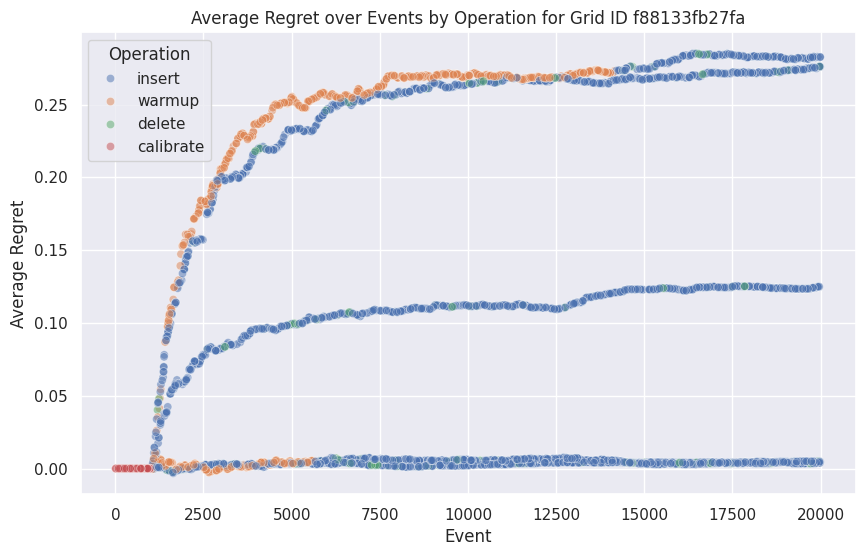

Grid ID: f2a5194fc897, shape: (5000, 3)


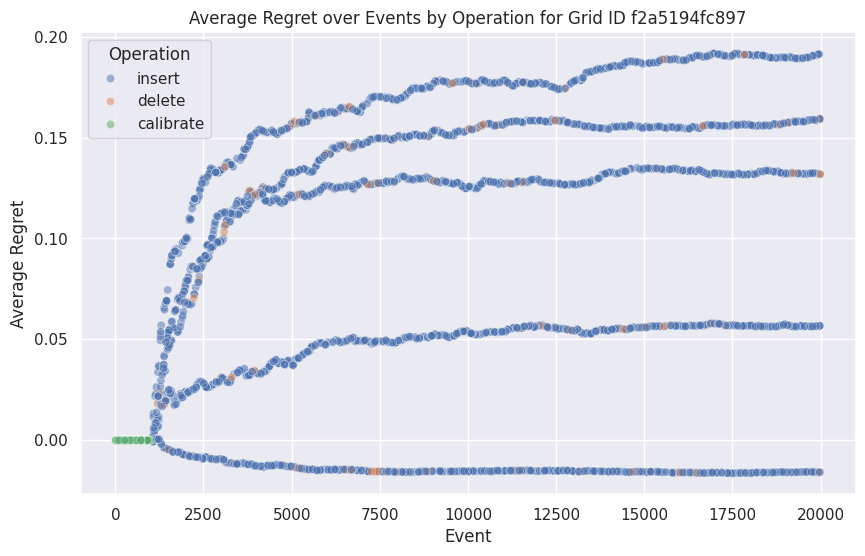

In [12]:
# plot one grid id per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols and 'event' in cols and 'op' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        grid_events = con.execute(f"SELECT event, avg_regret, op FROM events WHERE grid_id = '{gid}'").df()
        grid_events = grid_events.sample(n=min(5000, len(grid_events)), random_state=42)
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        if sns is not None:
            plt.figure(figsize=(10,6))
            sns.scatterplot(data=grid_events, x='event', y='avg_regret', hue='op', alpha=0.5)
            plt.title(f'Average Regret over Events by Operation for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.legend(title='Operation')
            plt.show()
        else:
            plt.figure(figsize=(10,6))
            for op_type in grid_events['op'].unique():
                subset = grid_events[grid_events['op'] == op_type]
                plt.scatter(subset['event'], subset['avg_regret'], alpha=0.5, label=op_type)
            plt.title(f'Average Regret over Events by Operation for Grid ID {gid}')
            plt.xlabel('Event')
            plt.ylabel('Average Regret')
            plt.legend(title='Operation')
            plt.show()